In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from casadi.tools.graph import dotgraph

from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())


import sys
sys.path.insert(0, '../python/pyecca')

from pyecca.util import rk4

cos = ca.cos
sin = ca.sin

In [2]:
def derive_equations():
    p_x = ca.SX.sym('p_x')
    p_z = ca.SX.sym('p_z')
    theta = ca.SX.sym('theta')
    omega = ca.SX.sym('omega')
    v = ca.SX.sym('v')
    g = ca.SX.sym('g')
    t = ca.SX.sym('t')

    x = ca.vertcat(p_x, p_z, theta)
    u = ca.vertcat(omega)
    p = ca.vertcat(v, g)

    dx = ca.vertcat(u*cos(theta), u*ca.sin(theta), omega)
    return {
        'rhs': ca.Function('rhs', [x, u, p], [dx])
    }

In [3]:
def objective(eqs, x, u_vect, p):
    return ca.dot(u_vect, u_vect)

def constraint(eqs, x, u_vect, p):
    u = u_vect[-1]
    x_dot = eqs['rhs'](x, u, p)
    return ca.vertcat(
        x[1] -10,  # be at 10 m altitude
        x_dot[2]  # don't rotate
    )
    
def optimize_trajectory(eqs, x0, p, t0, tf, h):
    # symbolic integration
    x = x0
    
    t_vect = np.arange(t0, tf, h)
    n = len(t_vect)
    u_vect = ca.SX.sym('u', n)
    x_vect = x0

    for t, u in zip(t_vect, u_vect):
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
        x_vect = ca.horzcat(x_vect, x)
    
    # NLP declaration
    nlp = {'x':u_vect,'f':objective(eqs, x, u_vect, p),'g':constraint(eqs, x , u_vect, p)};
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    n_g = 2
    res = S(x0=np.zeros(n),
        lbg=np.zeros(n_g), ubg=np.zeros(n_g), lbx=-5*np.ones(n), ubx=5*np.ones(n))
    stats = S.stats()
    print(stats['return_status'])
    u_opt = res['x']
    return t_vect, u_opt, x

def simulate(eqs, x0, p, t_vect, u_opt):
    data = {
        't': [],
        'x': [],
        'u': []
    }
    x = x0
    h = t_vect[1] - t_vect[0] # assumes equally spaced
    for t, u in zip(t_vect, u_opt):
        data['t'].append(t)
        data['u'].append(u)
        data['x'].append(np.reshape(x, -1))
        x = rk4(lambda t, x: eqs['rhs'](x, u, p), t, x, h)
    for k in data.keys():
        data[k] = np.array(data[k], dtype=float)
    return data

p = ca.vertcat(10, 9.8)
eqs = derive_equations()
x0 = ca.DM([0, 0, ca.pi/2])
t_vect, u_opt, x = optimize_trajectory(eqs, x0, p, 0, 1, 0.01)
data = simulate(eqs, x0, p, t_vect, u_opt)

Infeasible_Problem_Detected


In [4]:
#draw_graph(x)

$ J = \int (x^T Q x + u^T R u) dt$

Text(0, 0.5, 'z')

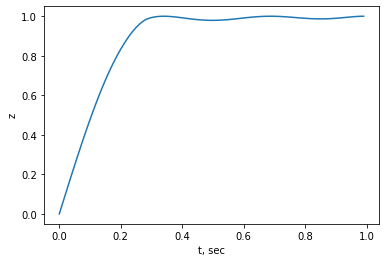

In [5]:
plt.plot(data['t'], data['x'][:, 1])
plt.xlabel('t, sec')
plt.ylabel('z')

Text(0, 0.5, 'u')

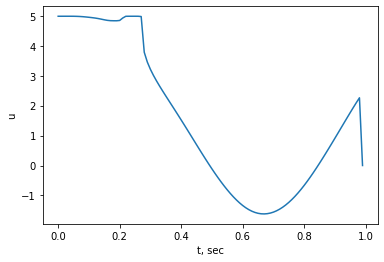

In [6]:
plt.plot(data['t'], data['u'])
plt.xlabel('t, sec')
plt.ylabel('u')